In [152]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from transformers import pipeline, SegformerImageProcessor, SegformerForSemanticSegmentation
import requests
from PIL import Image
import urllib.parse as parse
import os

In [153]:
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")

/Users/kirill/.pyenv/versions/3.10.11/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [154]:
# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# a function to load an image
def load_image(image_path):
    """Helper function to load images from their URLs or paths."""
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

In [155]:
# convert PIL Image to pytorch tensors
img_path = "pictures/5e65508b43b3c10fe35c60e23ab57eb8.jpg"
image = load_image(img_path)

In [156]:
transform = transforms.ToTensor()
image_tensor = image.convert("RGB")
image_tensor = transform(image_tensor)

In [157]:
def color_palette():
    """Color palette to map each class to its corresponding color."""
    return [[0, 128, 128],
            [255, 170, 0],
            [161, 19, 46],
            [118, 171, 47],
            [255, 255, 0],
            [84, 170, 127],
            [170, 84, 127],
            [33, 138, 200],
            [255, 84, 0],
            [0, 118, 255],
            [0, 84, 255],
            [0, 0, 255],
            [0, 255, 255],
            [0, 255, 0]]

In [158]:
def overlay_segments(image, seg_mask):
    """Return different segments predicted by the model overlaid on image."""
    H, W = seg_mask.shape
    image_mask = np.zeros((H, W, 3), dtype=np.uint8)
    colors = np.array(color_palette())
    # convert to a pytorch tensor if seg_mask is not one already
    seg_mask = seg_mask if torch.is_tensor(seg_mask) else torch.tensor(seg_mask)
    unique_labels = torch.unique(seg_mask)
    # map each segment label to a unique color
    for i, label in enumerate(unique_labels):
        image_mask[seg_mask == label.item(), :] = colors[i]
    image = np.array(image)
    # percentage of original image in the final overlaid iamge
    img_weight = 0.5
    # overlay input image and the generated segment mask
    img = img_weight * np.array(image) * 255 + (1 - img_weight) * image_mask
    return img.astype(np.uint8)

In [159]:
def to_tensor(image):
    """Convert PIL Image to pytorch tensor."""
    transform = transforms.ToTensor()
    image_tensor = image.convert("RGB")
    image_tensor = transform(image_tensor)
    return image_tensor

# a function that takes an image and return the segmented image
def get_segmented_image(model, feature_extractor, image_path):
    """Return the predicted segmentation mask for the input image."""
    # load the image
    image = load_image(image_path)
    # preprocess input
    inputs = feature_extractor(images=image, return_tensors="pt")
    # convert to pytorch tensor
    image_tensor = to_tensor(image)
    # pass the processed input to the model
    outputs = model(**inputs)
    print("outputs.logits.shape:", outputs.logits.shape)
    # interpolate output logits to the same shape as the input image
    upsampled_logits = F.interpolate(
        outputs.logits, # tensor to be interpolated
        size=image_tensor.shape[1:], # output size we want
        mode='bilinear', # do bilinear interpolation
        align_corners=False)

    # get the class with max probabilities
    segmentation_mask = upsampled_logits.argmax(dim=1)[0]
    print(f"{segmentation_mask.shape=}")
    # get the segmented image
    segmented_img = overlay_segments(image_tensor.permute(1, 2, 0), segmentation_mask)
    # convert to PIL Image
    return Image.fromarray(segmented_img)

In [160]:
def replace_label(mask, label):
  """Replace the segment masks values with label."""
  mask = np.array(mask)
  mask[mask == 255] = label
  return mask

In [161]:
img_segmentation_pipeline = pipeline('image-segmentation',
                                     model="nvidia/segformer-b0-finetuned-cityscapes-512-1024")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [162]:
output = img_segmentation_pipeline(image)
output

[{'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'sidewalk',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'traffic light',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'traffic sign',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=1200x800>},
 {'score': None,
  'label': 'truck',
  

In [163]:
len(output)

11

In [164]:
# load the feature extractor (to preprocess images) and the model (to get outputs)
W, H = image.size
segmentation_mask = np.zeros((H, W), dtype=np.uint8)

for i in range(len(output)):
    segmentation_mask += replace_label(output[i]['mask'], i)

In [165]:
# overlay the predicted segmentation masks on the original image
segmented_img = overlay_segments(image_tensor.permute(1, 2, 0), segmentation_mask)

# convert to PIL Image
converted_img = Image.fromarray(segmented_img)

In [166]:
# get_segmented_image(model, feature_extractor, img_path)

In [167]:
# show converted image
converted_img.show()

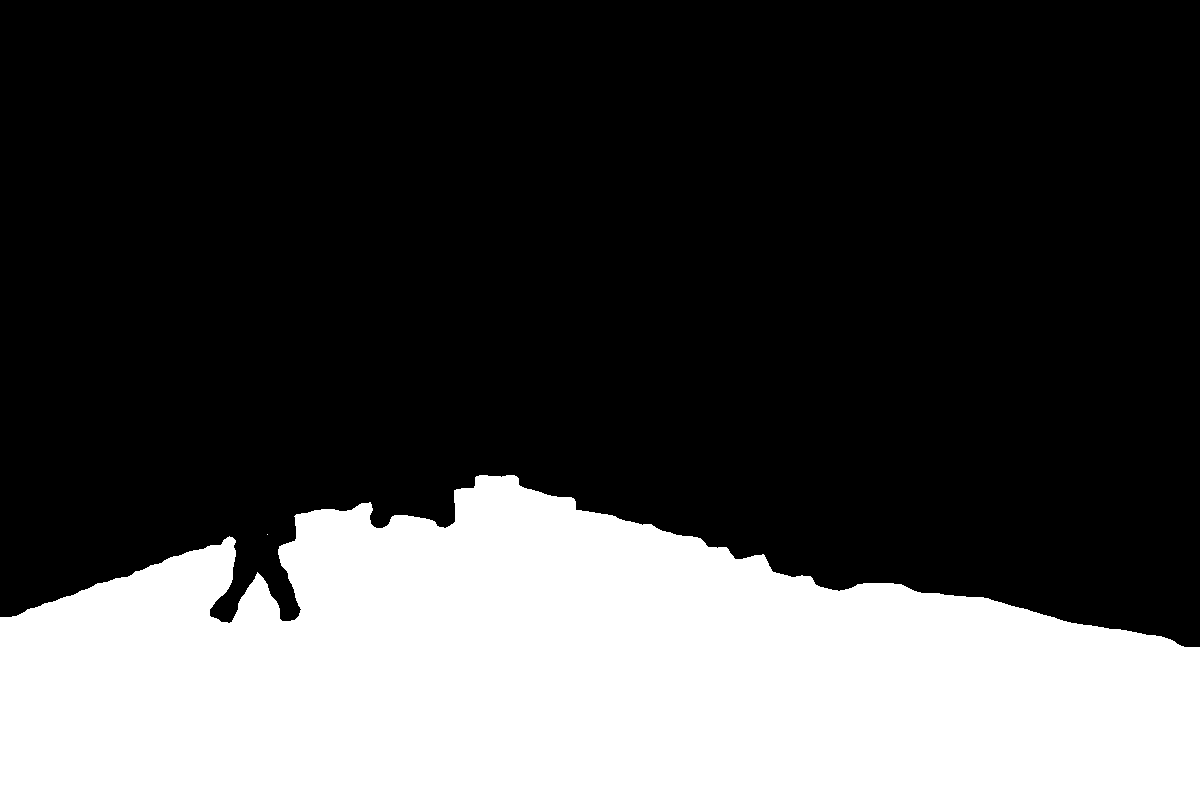

In [168]:
output[0]['mask']

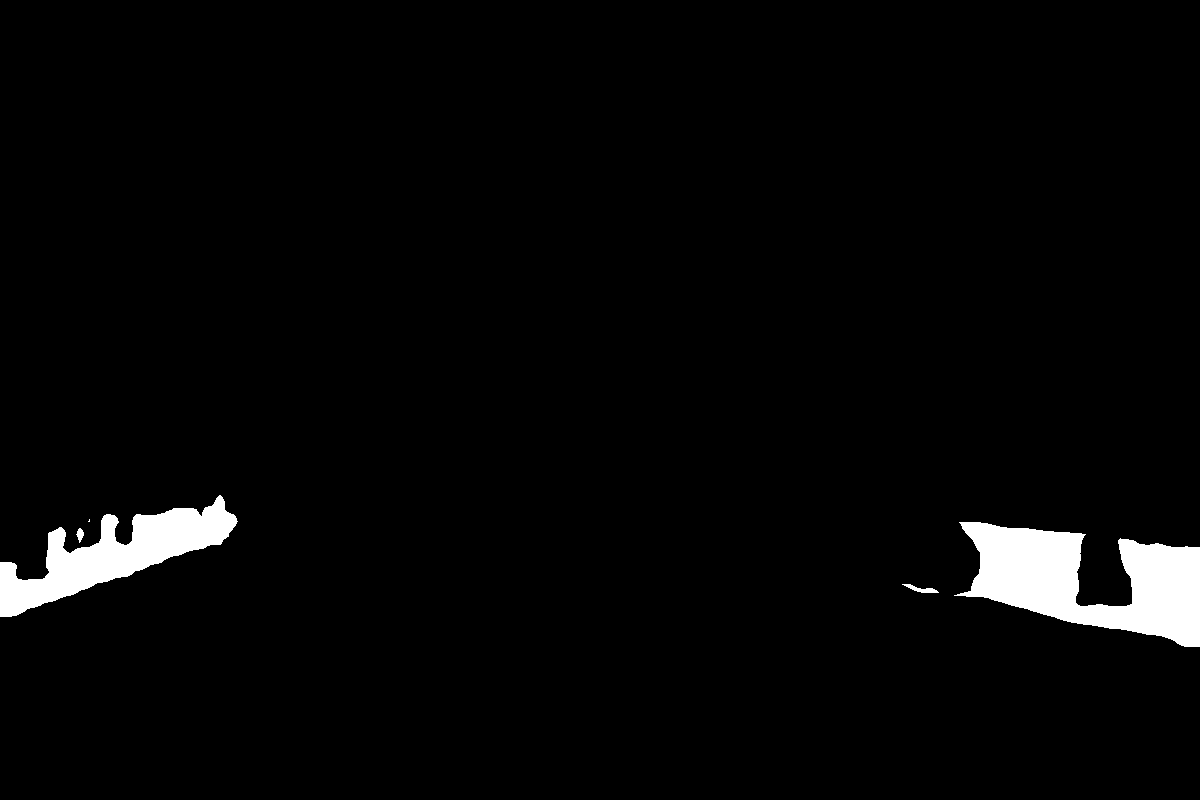

In [169]:
output[1]['mask']

In [170]:
# segmented_image_from_func = get_segmented_image(model, feature_extractor, img_path)

In [171]:
# segmented_image_from_func.show()

In [172]:
# show only road
road = np.zeros((H, W), dtype=np.uint8)
road[segmentation_mask == 0] = 1

In [173]:
side_walk = np.zeros((H, W), dtype=np.uint8)
side_walk[segmentation_mask == 1] = 1

In [174]:
road.shape

(800, 1200)

In [175]:
np.mean(road[-100:-1, W//2-100:W//2+100])

1.0

In [176]:
def detect_location(mask):
    """Detect the location of the object in the image."""
    H, W = mask.shape

    detection_cof_h = int(H * 0.05)
    detection_cof_w = int(W * 0.05)

    detection_area = [-detection_cof_h, -1, W//2-detection_cof_w, W//2+detection_cof_w]

    location_label = {
        'road': 0,
        'side_walk': 0,
    }

    for i, key in enumerate(location_label):
        way = np.zeros((H, W), dtype=np.uint8)
        way[mask == i] = 1

        location_label[key] = (np.mean(way[detection_area[0]:detection_area[1], detection_area[2]:detection_area[3]]) > 0.8) * 1

    return location_label


In [177]:
detect_location(segmentation_mask)

{'road': 1, 'side_walk': 0}

In [187]:
road = np.zeros((H, W), dtype=np.uint8)
road[segmentation_mask == 0] = 1

cof_h = int(H * 0.05)
cof_w = int(W * 0.05)

center_w = W//2

left_dist = []
right_dist = []

for i in range(-1, -cof_h, -1):
    for j in range(center_w, 0, -1):
        if road[i, j] == 0:
            left_dist.append(center_w - j)
            break
    left_dist.append(center_w - 0)

    for j in range(center_w, W):
        if road[i, j] == 0:
            right_dist.append(j - center_w)
            break
    right_dist.append(W - center_w)

In [190]:
np.median(left_dist)

600.0

In [191]:
np.median(right_dist)

600.0